## UnitVelo Import libraries


In [1]:
import unitvelo as utv
import anndata
import scvelo as scv
import numpy as np
import os
import argparse
import time
import anndata
import numpy as np
import scvelo as scv
import scanpy as sc
import sys
import torch
import os
import anndata as ad
os.environ['TF_USE_LEGACY_KERAS'] = 'True'

(Running UniTVelo 0.2.5.2)
2024-10-01 04:30:36


## Load cell cycle dataset, run UnitVelo and save the output in adata

In [2]:
import pandas as pd
adata = sc.read("/gpfs/home/jw7078/adata.h5ad")
adata.X = adata.layers["spliced"].copy()

del adata.layers["ambiguous"]
del adata.layers["matrix"]
del adata.layers["spanning"]

adata.obs.drop(
    ["Well_Plate", "plate", "MeanGreen530", "MeanRed585", "initial_size_unspliced", "initial_size_spliced", "initial_size"],
    axis=1,
    inplace=True
)

adata.var_names = adata.var["name"].values
adata.var.drop(adata.var.columns, axis=1, inplace=True)

adata.obs["pseudo_clusters"] = pd.cut(adata.obs["fucci_time"], bins=5, labels=False).astype(str).astype("category")

adata.obs["pseudo_clusters_equal_size"] = pd.qcut(adata.obs["fucci_time"], q=5, labels=False)
adata.obs["pseudo_clusters_equal_size_num"] = adata.obs["pseudo_clusters_equal_size"].astype(float)

adata.obs["cell_cycle_rad"] = adata.obs["fucci_time"] / adata.obs["fucci_time"].max() * 2 * np.pi

Filtered out 4748 genes that are detected 10 counts (spliced).
Normalized count data: X, spliced, unspliced.
Extracted 2000 highly variable genes.
Logarithmized X.
computing neighbors
    finished (0:00:06) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)
computing moments based on connectivities
    finished (0:00:00) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)
computing velocities
    finished (0:00:00) --> added 
    'velocity', velocity vectors for each individual cell (adata.layers)
computing velocity graph (using 1/48 cores)


  0%|          | 0/1146 [00:00<?, ?cells/s]

    finished (0:00:01) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)
computing velocity embedding
    finished (0:00:00) --> added
    'velocity_umap', embedded velocity vectors (adata.obsm)


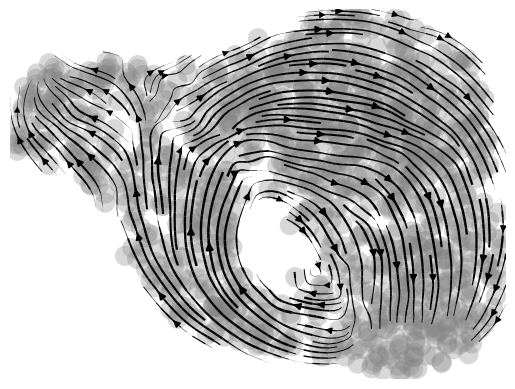

computing neighbors
    finished (0:00:00) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)


In [3]:
scv.pp.filter_and_normalize(adata, min_counts=10,n_top_genes = 2000)
scv.pp.moments(adata, n_pcs=30, n_neighbors=30)

scv.tl.velocity(adata, mode='stochastic')

scv.tl.velocity_graph(adata)
sc.tl.umap(adata)

scv.pl.velocity_embedding_stream(adata, dpi=100)
scv.pp.neighbors(adata)


In [4]:
velo_config = utv.config.Configuration()
velo_config.R2_ADJUST = True
velo_config.IROOT = None
velo_config.FIT_OPTION = '1'
velo_config.AGENES_R2 = 1
velo_config.GPU = -1

------> Manully Specified Parameters <------
GPU:	-1
------> Model Configuration Settings <------
N_TOP_GENES:	2000
LEARNING_RATE:	0.01
FIT_OPTION:	1
DENSITY:	SVD
REORDER_CELL:	Soft_Reorder
AGGREGATE_T:	True
R2_ADJUST:	True
GENE_PRIOR:	None
VGENES:	basic
IROOT:	None
--------------------------------------------

Current working dir is /gpfs/home/jw7078/VeloVI-RegVelo-time_bug_fix/VeloVAE/notebooks.
Results will be stored in res folder
Filtered out 376 genes that are detected 20 counts (shared).
Skip filtering by dispersion since number of variables are less than `n_top_genes`.
Extracted 1624 highly variable genes.
Computing moments for 1624 genes with n_neighbors: 30 and n_pcs: 30
computing moments based on connectivities
    finished (0:00:00) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)

# of velocity genes 471 (Criterion: positive regression coefficient between un/spliced counts)
# of velocity genes 428 (Criterion: std of un/spliced reads should be mo

Loss (Total): 539696.132, (Spliced): 295386.364, (Unspliced): 244309.768: 100%|█████████▉| 11996/12000 [05:41<00:00, 31.31it/s]

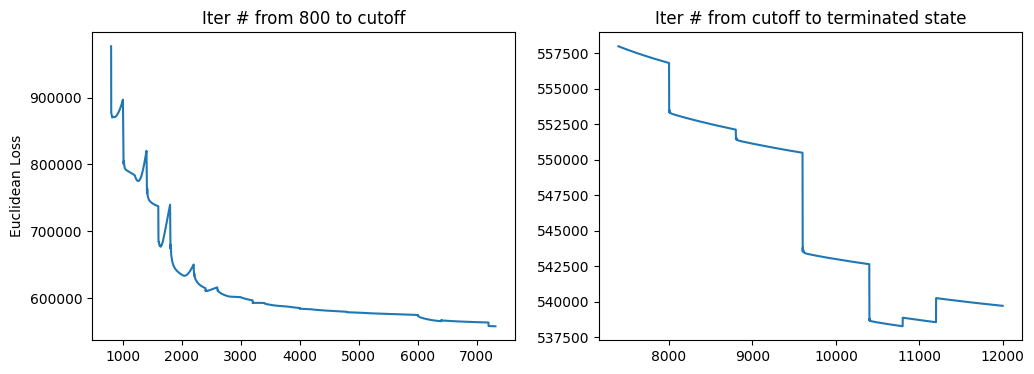

Loss (Total): 539696.132, (Spliced): 295386.364, (Unspliced): 244309.768: 100%|█████████▉| 11999/12000 [05:46<00:00, 34.60it/s]

Total loss 538254.109, vgene loss 539696.132


  0%|          | 0/1146 [00:00<?, ?cells/s]

... storing 'cluster' as categorical


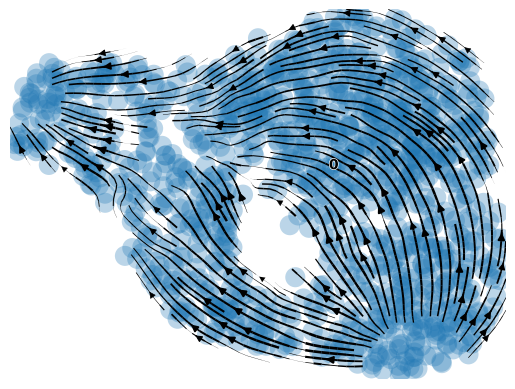

In [5]:
adata.obs["cluster"] = "0"
os.environ['TF_USE_LEGACY_KERAS'] = 'True'

adata = utv.run_model(adata, label='cluster', config_file=velo_config)
scv.pl.velocity_embedding_stream(adata, color=adata.uns['label'], dpi=100, title='')


In [6]:
adata

AnnData object with n_obs × n_vars = 1146 × 1624
    obs: 'phase', 'fucci_time', 'pseudo_clusters', 'pseudo_clusters_equal_size', 'pseudo_clusters_equal_size_num', 'cell_cycle_rad', 'initial_size_unspliced', 'initial_size_spliced', 'initial_size', 'n_counts', 'velocity_self_transition', 'cluster', 'root_cells', 'end_points', 'velocity_pseudotime', 'latent_time'
    var: 'gene_count_corr', 'means', 'dispersions', 'dispersions_norm', 'highly_variable', 'velocity_gamma', 'velocity_qreg_ratio', 'velocity_r2', 'velocity_genes', 'scaling', 'fit_vars', 'fit_varu', 'fit_gamma', 'fit_beta', 'fit_offset', 'fit_a', 'fit_t', 'fit_h', 'fit_intercept', 'fit_loss', 'fit_llf', 'fit_sr2', 'fit_ur2'
    uns: 'pca', 'neighbors', 'velocity_params', 'velocity_graph', 'velocity_graph_neg', 'umap', 'temp', 'datapath', 'label', 'base_function', 'basis', 'par_names', 'loss', 'cluster_colors'
    obsm: 'X_pca', 'X_umap', 'velocity_umap'
    varm: 'PCs'
    layers: 'spliced', 'unspliced', 'Ms', 'Mu', 'velocity',

In [7]:
adata.write('unitvelo_cycle.h5ad')